# 文心大模型 SFT 最佳实践

# 1 SFT 简介
### 1.1 什么是 SFT
SFT（Supervised Fine-Tuning，监督精调）是定制化精调预训练大模型的关键技术。用**少量、高质量标注数据**继续训练模型，可以低成本、快速地提升模型在特定领域的表现。

### 1.2 SFT 适用范围
- ✅ 适用
  - 任务适配，强化模型对特定任务的理解（如文本分类、信息抽取）；
  - 强化已存在的能力效果或强调模型已具备的知识；
  - 教会模型完成更复杂的组合任务（需要模型已具备完成相关子任务的能力）。

- ❌ 不适用
  - 给模型添加新的内化知识；
  - 强迫模型学会不具备的能力；
  - 完全纠正预训练模型中的固有偏差；
  - 应对需要复杂推理或长期记忆的场景（需结合强化学习等）。


### 1.3 SFT 的一般步骤
1. 构造评估数据、评估标准，测试模型基础能力，分析其短板、问题。
2. 进行充分的 prompt 工程。
3. 判断是否适用 SFT；准备训练数据。
4. 训练。结合任务特点、数据情况，设计训练参数。一般关注以下核心参数：
    - 批处理大小
    - 训练轮数、最大训练步数
    - 学习率类型、学习率初始值
    - 预热步数
5. 效果评估。采用相同的评估数据、评估标准，评估训练后的模型表现。若效果不达标，考虑继续优化训练数据、调整训练参数。

# 2 最佳实践任务简介
### 2.1 任务描述
我们选择工具调用（function-call）任务作为最佳实践的示例：给定若干工具函数、多轮对话，模型根据对话语境，从若干工具函数中选择最合适的完成任务。简单起见，输出工具函数的名称即可。

### 2.2 名词解释
为了便于理解，我们定义如下概念。  
- **session**：一组多轮对话，包括多个问答对
- **round**：一个对话轮次，包括一问一答
- **history**：OpenAI API 格式的 session 数据

### 2.3 数据来源
我们使用开源社区内较为流行的 glaive_toolcall 数据集（[链接](https://huggingface.co/datasets/llamafactory/glaive_toolcall_zh)）。该数据集有中、英文数据各1千条，采用 ShareGPT 格式，具有以下字段：
- `conversations`：对话上下文，[{"from": "", "value": ""}] 格式，其中 `from` 字段包括
  - `human`：用户输入
  - `gpt`：模型输入（这里用 gpt 指代了大模对话助手）
  - `function_call`：调用哪项工具以及工具参数
  - `observation`：工具调用结果
- `tools`：备选工具列表以及工具描述

### 2.4 评估标准
这是一个多选一任务，我们采用准确率、宏平均、微平均、加权平均指标评价模型表现。

### 2.5 实验环境
本教程采用以下环境：
- 1张 80GB A800 GPU
- CUDA 版本：12.3
- CUDA 驱动：525.125.06
- nvcc：12.3
- gcc：12.2
- Python 版本：3.10.12

### 2.6 依赖项
- **ERNIEKit**：文心大模型工具链，包含文心4.5系列模型训练-压缩-推理的全流程使用，基于飞桨框架v3.1可在多款主流国产芯片上进行训练。
- **ERNIEKit WebUI**：可视化界面，支持训练、对话交互、性能评估、模型导出等功能。[文档](../../docs/cli_webui_usage.md)
- **[可选]visualdl**：可视化 loss 等信息的工具，ERNIEKit 已包含。
- **ERNIEKit 推理脚本**。
- 本教程中的 **Python 依赖**。

In [1]:
# 本教程中的 Python 依赖
import json
import random
from collections import defaultdict
from string import Template

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

RANDOM_SEED = 2025

# 3 数据预处理

首先观察 glaive_toolcall 数据集。注意到这里存在同一 session 多次调用函数的情况。对于这类数据，我们以工具调用为界限，拆分为多个 session。  

进一步，我们依照 ERNIEKit 要求的训练、推理数据格式，整理 glaive_toolcall 数据集。
  - **训练数据**：`jsonl` 文件，每行 `{"system": "", "src": [], "tgt": [], "label": []}`
    - `system`(str, optional): 设定系统信息的  prompt，包括但不限于人物设定、任务说明、风格定义等等；
    - `src` (list(str))：用户多轮对话内容，以对话轮次排列，与 `tgt`一一对应；
    - `tgt` (list(str))：系统多轮回复内容，以对话轮次排列，与 `src` 一一对应；
    - `label` (list(int), optional)：标记当前对话轮次是否训练，填`1` 表示本轮参与训练（计算 loss），`0` 表示不参与；若省略该字段，则表示所有轮次均参与训练。 
  - **推理数据**：`jsonl` 文件，每行 `[{"role": "", "content": ""}]`, `role` 字段可填 `system`、`user`、`assistant`  

综合以上各数据集格式，我们考虑将 `glaive_toolcall` 数据集整理为以下格式：`jsonl` 文件，每行 `[{"role": "", "content": ""}]`, `role` 字段可填 `system`、`user`、`assistant`，其中`user`与`assistant`按对话顺序成对出现，最后一个`assistant`记录调用的工具名称。

### 3.1 准备原始数据
首先下载开源数据集。保存在 `cookbook/data/glaive_toolcall_zh_1k.json`。

![sft_download_dataset](https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/sft_download_dataset_zh.png)

为了便于处理，这里将 ShareGPT 格式转为 OpenAI API 格式，并记录工具调用情况。我们定义了若干数据预处理的函数。

In [2]:
def parse_function(tools, func_name_with_desc: dict):
    """解析工具列表，获取工具名称和描述

    Args:
        tools: 工具列表
        func_name_with_desc: 记录工具名称和描述对应关系的字典

    Returns:
        func_name_with_desc: 记录工具名称和描述对应关系的字典
    """
    for tool in tools:
        tool_name = tool.get("name", "")
        tool_desc = tool.get("description", "")
        func_name_with_desc[tool_name] = tool_desc
    return func_name_with_desc


def is_valid_history(history):
    """判断历史对话是否有效：user 和 assistant 成对出现, 且最后一轮为 assistant

    Args:
        history: OpenAI API 格式的多轮对话数据

    Returns:
        bool: 是否有效
    """
    # 如果有 system prompt 需要剔除，便于计算
    history = [h for h in history if h.get("role", "") != "system"]
    if len(history) < 2 or len(history) % 2 != 0:
        return False
    for i in range(1, len(history), 2):
        if history[i]["role"] != "assistant" or history[i - 1]["role"] != "user":
            return False
    else:
        return True


def conversations_to_history(conversations):
    """将 ShareGPT 格式的对话数据转换为 OpenAI API 格式的多轮对话数据

    Args:
        conversations: ShareGPT 格式的对话数据

    Yields:
        history: OpenAI API 格式的多轮对话数据
    """
    NO_FUNCTION_CALL_MARK = "<|NO_FUNCTION_CALL|>"
    had_function_call = False
    history = []
    for conversation in conversations:
        if conversation.get("from", "") == "human":
            history.append({"role": "user", "content": conversation.get("value", "")})
        elif conversation.get("from", "") == "function_call":
            history.append({"role": "assistant", "content": json.loads(conversation.get("value", "")).get("name", "")})
            if is_valid_history(history):
                yield history
                had_function_call = True
                history.pop()
                # 如果还有更多轮对话，『assistant』字段用原数据的『gpt』内容（而不是『function_call』），因此删去当前的『assistant』，为下一轮数据做准备

        elif conversation.get("from", "") == "gpt":
            if had_function_call:
                history.append({"role": "assistant", "content": conversation.get("value", "")})
                had_function_call = False
            else:
                history.append({"role": "assistant", "content": NO_FUNCTION_CALL_MARK})
                if is_valid_history(history):
                    yield history
                    history.pop()
                    history.append({"role": "assistant", "content": conversation.get("value", "")})
        else:
            pass


def history_to_train(history, system_prompt: str = ""):
    """将 OpenAI API 格式多轮对话转换为 ERNIE 训练数据格式

    Args:
        history: OpenAI API 格式的多轮对话数据

    Returns:
        data: ERNIE 格式的训练数据
    """
    data = {"system": system_prompt, "src": [], "tgt": [], "label": []}
    if not is_valid_history(history):
        return {}

    for h in history:
        role = h.get("role", "")
        content = h.get("content", "")
        if role == "user":
            data["src"].append(content)
        elif role == "assistant":
            data["tgt"].append(content)
        data["label"] = [0] * (len(data["tgt"]) - 1) + [1]
    return data


def history_to_test(history, system_prompt: str = ""):
    """将 OpenAI API 格式多轮对话转换为 ERNIE 测试数据格式

    Args:
        history: OpenAI API 格式的多轮对话数据

    Returns:
        data: ERNIE 格式的测试数据
    """
    return [{"role": "system", "content": system_prompt}] + history

调用以上函数处理数据。

In [3]:
raw_data_path = "../data/glaive_toolcall_zh_1k.json"
history_path = raw_data_path.replace('.json', '_history.jsonl')
func_name_with_desc = {}

with open(raw_data_path, "r") as fin:
    with open(history_path, "w") as fout:
        data_list = json.load(fin)
        for data in data_list:
            for history in conversations_to_history(data.get("conversations", [])):
                fout.write(json.dumps(history, ensure_ascii=False) + "\n")
            # 顺便记录 function call 信息
            parse_function(json.loads(data.get("tools", [])), func_name_with_desc)

func_name_with_desc["<|NO_FUNCTION_CALL|>"] = "无需调用任何工具"

### 3.2 分析原始数据
观察各个工具调用的情况，然后针对性构造测试集、训练集

In [4]:
func_cnt = {}
with open(history_path, 'r') as fin:
    for line in fin:
        data = json.loads(line)
        func_name = data[-1].get("content", "")
        func_cnt[func_name] = func_cnt.get(func_name, 0) + 1

func_cnt = dict(sorted(func_cnt.items(), key=lambda x: x[1], reverse=True))

对工具调用情况做简单可视化分析

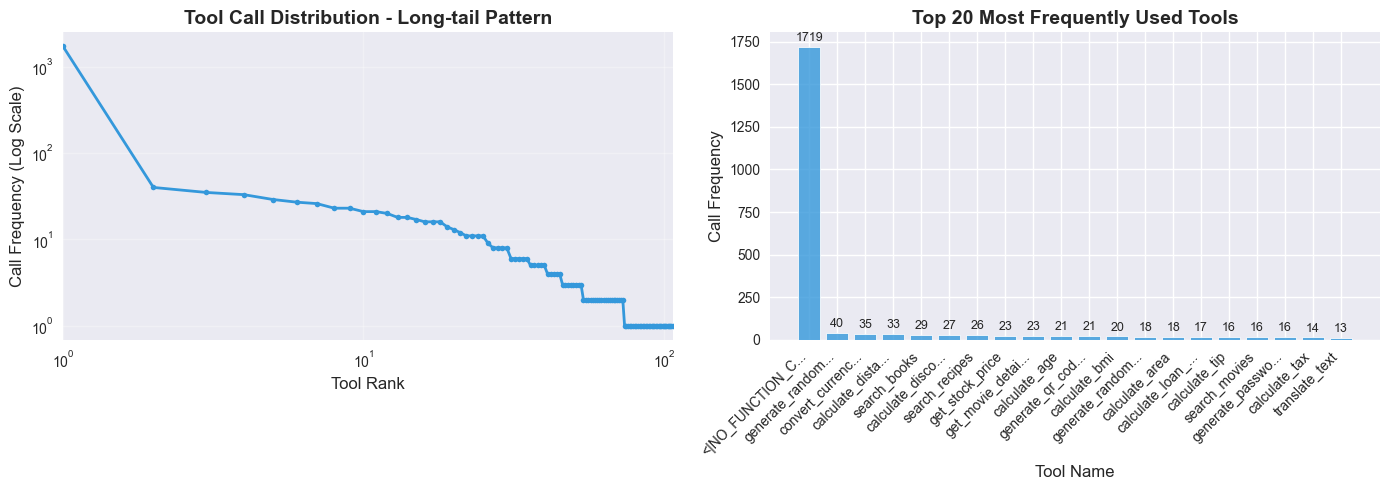

In [5]:
# 设置样式和图形
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 准备数据
tools = list(func_cnt.keys())
counts = list(func_cnt.values())

# 创建并排的子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 左图：长尾分布（对数刻度）
ax1.loglog(range(1, len(counts) + 1), counts, 'o-', linewidth=2, markersize=4, color='#3498db')
ax1.set_xlabel('Tool Rank', fontsize=12)
ax1.set_ylabel('Call Frequency (Log Scale)', fontsize=12)
ax1.set_title('Tool Call Distribution - Long-tail Pattern', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(1, len(counts))

# 右图：前20个工具的柱状图
top_20_tools = tools[:20]
top_20_counts = counts[:20]

# 截断工具名称以便更好显示
display_tools = [tool[:15] + "..." if len(tool) > 15 else tool for tool in top_20_tools]

bars = ax2.bar(range(len(top_20_tools)), top_20_counts, color='#3498db', alpha=0.8, edgecolor='white', linewidth=0.7)
ax2.set_xlabel('Tool Name', fontsize=12)
ax2.set_ylabel('Call Frequency', fontsize=12)
ax2.set_title('Top 20 Most Frequently Used Tools', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(top_20_tools)))
ax2.set_xticklabels(display_tools, rotation=45, ha='right')

# 在柱状图上添加数值标签
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max(top_20_counts)*0.01,
             f'{int(height)}', ha='center', va='bottom', fontsize=9)

# 调整布局
plt.tight_layout()
plt.show()

In [6]:
# 打印统计信息
total_tools = len(func_cnt)
total_calls = sum(func_cnt.values())
print(f"总工具数量: {total_tools}")
print(f"总调用次数: {total_calls}")
print(f"平均每个工具调用次数: {total_calls/total_tools:.2f}")
print(f"调用次数最多的工具: {tools[0]} ({counts[0]}次)")
print(f"只调用1次的工具数量: {sum(1 for c in counts if c == 1)}")
print(f"调用5次及以上的工具数量: {sum(1 for c in counts if c >= 5)}")

总工具数量: 107
总调用次数: 2415
平均每个工具调用次数: 22.57
调用次数最多的工具: <|NO_FUNCTION_CALL|> (1719次)
只调用1次的工具数量: 34
调用5次及以上的工具数量: 40


设置 system prompt。经过了简单实验，这里使用实验中表现较好的 system prompt。

In [7]:
system_prompt_template = Template(
    """你是一个智能助手，能根据用户需求找到最合适的工具完成任务。请参考以下工具列表来完成任务。注意：
1. 只返回工具名称，不要返回任何其他内容。
2. 不要执行任务本身，仅返回工具名称。例如，用户需要将摄氏度转换为华氏度，你只需要返回字符串『convert_temperature』。
3. 如果你认为无需调用任何工具，请返回字符串『<|NO_FUNCTION_CALL|>』。例如，用户仅询问常规信息，或用户明确要求不使用工具。
4. 只可以调用列表中的工具，不要无中生有。

可用的工具列表：
${tools_prompt}"""
)

In [8]:
tools_prompt = ""
for tool_name, tool_desc in func_name_with_desc.items():
    tools_prompt += f"工具名称: {tool_name}\n"
    tools_prompt += f"工具描述: {tool_desc}\n"
    tools_prompt += "\n"
tools_prompt = tools_prompt.strip()

### 3.3 评估模型基础能力
定义评估标准。

In [9]:
def calculate_multiclass_metrics(data):
    """
    计算多分类任务的准确率、精确率、召回率和F1分数

    Args:
        data: list，每个元素格式为 {"ground_truth": "", "prediction": ""}

    Returns:
        dict: 包含整体指标和各类别指标的字典
    """
    if not data:
        return {}

    # 提取所有真实标签和预测标签
    y_true = [item["ground_truth"] for item in data]
    y_pred = [item["prediction"] for item in data]

    # 只统计真实标签中出现的类别
    true_classes = set(y_true)

    # 计算整体准确率
    correct = sum(1 for gt, pred in zip(y_true, y_pred) if gt == pred)
    total = len(data)
    accuracy = correct / total if total > 0 else 0

    # 为每个真实类别计算指标
    class_metrics = {}
    precision_list = []
    recall_list = []
    f1_list = []
    support_list = []

    for cls in true_classes:
        # 计算TP, FP, FN
        tp = sum(1 for gt, pred in zip(y_true, y_pred) if gt == cls and pred == cls)
        fp = sum(1 for gt, pred in zip(y_true, y_pred) if gt != cls and pred == cls)
        fn = sum(1 for gt, pred in zip(y_true, y_pred) if gt == cls and pred != cls)

        # 计算精确率、召回率、F1（保持原始精度）
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        support = sum(1 for gt in y_true if gt == cls)

        class_metrics[cls] = {
            "precision": round(precision * 100, 3),
            "recall": round(recall * 100, 3),
            "f1_score": round(f1 * 100, 3),
            "support": support,
        }

        # 收集原始值用于计算平均值
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        support_list.append(support)

    # 计算宏平均（macro average）- 使用原始精度值
    macro_precision = sum(precision_list) / len(precision_list) if precision_list else 0
    macro_recall = sum(recall_list) / len(recall_list) if recall_list else 0
    macro_f1 = sum(f1_list) / len(f1_list) if f1_list else 0

    # 计算微平均（micro average）
    total_tp = sum(sum(1 for gt, pred in zip(y_true, y_pred) if gt == cls and pred == cls) for cls in true_classes)
    total_fp = sum(sum(1 for gt, pred in zip(y_true, y_pred) if gt != cls and pred == cls) for cls in true_classes)
    total_fn = sum(sum(1 for gt, pred in zip(y_true, y_pred) if gt == cls and pred != cls) for cls in true_classes)

    micro_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    micro_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    micro_f1 = (
        2 * micro_precision * micro_recall / (micro_precision + micro_recall)
        if (micro_precision + micro_recall) > 0
        else 0
    )

    # 计算加权平均（weighted average）- 使用原始精度值
    total_support = sum(support_list)
    weighted_precision = (
        sum(p * s for p, s in zip(precision_list, support_list)) / total_support if total_support > 0 else 0
    )
    weighted_recall = sum(r * s for r, s in zip(recall_list, support_list)) / total_support if total_support > 0 else 0
    weighted_f1 = sum(f * s for f, s in zip(f1_list, support_list)) / total_support if total_support > 0 else 0

    return {
        "accuracy": f"{round(accuracy * 100, 3)}%",
        "macro_avg": {
            "precision": f"{round(macro_precision * 100, 3)}%",
            "recall": f"{round(macro_recall * 100, 3)}%",
            "f1_score": f"{round(macro_f1 * 100, 3)}%",
        },
        "micro_avg": {
            "precision": f"{round(micro_precision * 100, 3)}%",
            "recall": f"{round(micro_recall * 100, 3)}%",
            "f1_score": f"{round(micro_f1 * 100, 3)}%",
        },
        "weighted_avg": {
            "precision": f"{round(weighted_precision * 100, 3)}%",
            "recall": f"{round(weighted_recall * 100, 3)}%",
            "f1_score": f"{round(weighted_f1 * 100, 3)}%",
        },
        "per_class": class_metrics,
        "total_samples": total,
        "correct_predictions": correct,
    }

构造测试集。根据以上观察分析，原始数据集的 function 分布很不均衡，我们重点关注那些至少有5个样本的 function，每个 function 随机取2条。

In [10]:
with open(history_path, "r") as fin:
    all_histories = [json.loads(line) for line in fin]

# 找出调用频繁的工具
frequent_funcs = {func_name: count for func_name, count in func_cnt.items() if count >= 5}

# 找到调用频繁的工具所对应的对话索引
history_idx_called_frequent_func = defaultdict(list)
for idx, history in enumerate(all_histories):
    func_name = history[-1].get("content", "")
    if func_name in frequent_funcs:
        history_idx_called_frequent_func[func_name].append(idx)

random.seed(RANDOM_SEED)
test_indices = set()
for tool, history_indices in history_idx_called_frequent_func.items():
    selected = random.sample(history_indices, 2)
    test_indices.update(selected)

# 保存测试集，无真值的用于推理，有真值的用于评估
testset_no_gt_path = "../data/sft_testset_no_gt.jsonl"
testset_has_gt_path = "../data/sft_testset_has_gt.jsonl"
with open(testset_no_gt_path, "w") as no_gt, open(testset_has_gt_path, "w") as has_gt:
    for idx in test_indices:
        testset_history = all_histories[idx]
        ground_truth = testset_history.pop().get("content", "")
        no_gt.write(
            json.dumps(
                history_to_test(
                    history=testset_history, system_prompt=system_prompt_template.substitute(tools_prompt=tools_prompt)
                ),
                ensure_ascii=False,
            )
            + "\n"
        )
        has_gt.write(json.dumps({"history": testset_history, "ground_truth": ground_truth}, ensure_ascii=False) + "\n")

使用原始模型推理测试集。当前 WebUI 暂不支持推理测试集，我们使用 ERNIEKit 代码库中的推理脚本操作。
- **脚本**：`tools/inference/scripts/infer.sh`
- **设置主要的超参数**
  - `top_p=0.7`
  - `temperature=0.7`
  - `max_seq_len=128000`（ERNIE-4.5-0.3B 支持动态128K 上下文长度）
  - `max_dec_len=64`（我们的任务不需要输出太多 token）
  - `weight_quantize_algo` 如果训练时未使用量化可删去此行

> 推理过程略

计算评估指标。

In [11]:
# 获取推理结果
prediction_data_path = "../data/infer/sft_03b_exp0.jsonl"

# 为防止推理结果是乱序的，这里我们重新整理，将推理结果与输入信息对应起来
history2gt = {}
with open(testset_has_gt_path, "r") as fin:
    for line in fin:
        data_eval = json.loads(line.strip())
        history2gt[json.dumps(data_eval["history"], ensure_ascii=False)] = data_eval["ground_truth"]

history2pred = {}
with open(prediction_data_path, "r") as fin:
    for line in fin:
        data_pred = json.loads(line.strip())
        history2pred[json.dumps(data_pred[1:-1], ensure_ascii=False)] = data_pred[-1]["content"]

pred2gt = []
for history, pred in history2pred.items():
    pred2gt.append({"ground_truth": history2gt[history], "prediction": pred})

# 计算多分类指标
results = calculate_multiclass_metrics(pred2gt)
print("评估结果:")
print(f"准确率: {results['accuracy']}")
print(
    f"宏平均 - 精确率: {results['macro_avg']['precision']}, 召回率: {results['macro_avg']['recall']}, F1: {results['macro_avg']['f1_score']}"
)
print(
    f"微平均 - 精确率: {results['micro_avg']['precision']}, 召回率: {results['micro_avg']['recall']}, F1: {results['micro_avg']['f1_score']}"
)
print(
    f"加权平均 - 精确率: {results['weighted_avg']['precision']}, 召回率: {results['weighted_avg']['recall']}, F1: {results['weighted_avg']['f1_score']}"
)


# 将 per_class 结果转换为 DataFrame，便于分析
per_class_data = []
for class_name, metrics in results['per_class'].items():
    per_class_data.append(
        {
            '类别': class_name,
            '精确率(%)': str(metrics['precision']).rstrip('%'),
            '召回率(%)': str(metrics['recall']).rstrip('%'),
            'F1分数(%)': str(metrics['f1_score']).rstrip('%'),
            '支持数': metrics['support'],
        }
    )

df_per_class = pd.DataFrame(per_class_data)
print("\n各类别详细指标:")
df_per_class

评估结果:
准确率: 2.532%
宏平均 - 精确率: 2.75%, 召回率: 2.5%, F1: 2.083%
微平均 - 精确率: 5.714%, 召回率: 2.532%, F1: 3.509%
加权平均 - 精确率: 2.785%, 召回率: 2.532%, F1: 2.11%

各类别详细指标:


,类别,精确率(%),召回率(%),F1分数(%),支持数
0,calculate_discount,0,0.0,0,2
1,search_movies,0,0.0,0,2
2,create_note,0,0.0,0,2
3,search_books,0,0.0,0,2
4,calculate_tax,0,0.0,0,2
5,<|NO_FUNCTION_CALL|>,0.0,0.0,0,2
6,generate_password,0,0.0,0,2
7,check_email_availability,0,0.0,0,2
8,search_recipe,0,0.0,0,2
9,generate_random_number,0,0.0,0,1


### 3.4 构造训练集
可见，当前模型完全不会选择合适的工具函数，SFT 是必要的。于是我们构造训练集、验证集。不属于测试集的数据划分10%作为验证集，其余作为训练集。

In [12]:
trainset_path = "../data/sft_trainset.jsonl"
validset_path = "../data/sft_validset.jsonl"

# 从非测试集数据中划分验证集
remaining_indices = [idx for idx in range(len(all_histories)) if idx not in test_indices]
random.shuffle(remaining_indices)
valid_size = int(len(remaining_indices) * 0.1)
valid_indices = set(remaining_indices[:valid_size])
train_indices = set(remaining_indices[valid_size:])

# 保存训练集
with open(trainset_path, "w") as fout:
    for idx in train_indices:
        history = all_histories[idx]
        train_data = history_to_train(
            history=history, system_prompt=system_prompt_template.substitute(tools_prompt=tools_prompt)
        )
        fout.write(json.dumps(train_data, ensure_ascii=False) + "\n")

# 保存验证集
with open(validset_path, "w") as fout:
    for idx in valid_indices:
        history = all_histories[idx]
        valid_data = history_to_train(
            history=history, system_prompt=system_prompt_template.substitute(tools_prompt=tools_prompt)
        )
        fout.write(json.dumps(valid_data, ensure_ascii=False) + "\n")

# 4 训练
### 4.1 选择基础模型
考虑到展示的便利性与任务的复杂性，我们选择尺寸较小的 ERNIE-4.5-0.3B 模型。

### 4.2 设计训练参数
设计训练参数较为依赖经验。ERNIEKit 支持用户仅设置少量训练参数、自动推荐其余参数的功能。一般情况下需要用户设置的关键参数如下：
- num_train_epochs
- gradient_accumulation_steps
- max_seq_len=8192

计算推荐参数（详见 `examples/post-training/sft/README.md`）：
```bash
python examples/post-training/sft/estimate_training.py \
    --train_dataset_path examples/data/sft-train.jsonl \
    --train_dataset_type erniekit \
    --train_dataset_prob 1.0 \
    --model_name_or_path baidu/paddle_internal/ERNIE-4.5-0.3B \
    --out_file estimate_training.json \
    --num_train_epochs 1 \
    --max_seq_len 8192 \
    --num_of_gpus 1 \
    --per_device_train_batch_size 1 \
    --tensor_parallel_degree 1 \
    --pipeline_parallel_degree 1 \
    --sharding_parallel_degree 1 \
    --seed 23 \
    --num_samples_each_epoch 6000000
```

### 4.3 使用 WebUI 训练
1. 在 ERNIEKit 项目的根目录启动 WebUI：`erniekit webui`  
2. 配置模型路径及导出目录  

![sft_set_path](https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/sft_set_path_zh.png)

3. 设置全参数/LoRA 精调、数值精度等  

![sft_set_lora](https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/sft_set_lora_zh.png)

4. 设置精调模式（SFT/DPO），并配置训练参数  

![sft_train_params](https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/sft_train_params_zh.png)

5. 配置训练集、验证集

<div style="display: flex; justify-content: space-around;">
    <img src="https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/sft_trainset_zh.png" alt="sft_trainset" style="width: 49%;">
    <img src="https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/sft_validset_zh.png" alt="sft_validset" style="width: 49%;">
</div>

### 4.4 查看训练日志及 loss 曲线
训练日志路径：`${your_model_dir}/paddle_dist_log/workerlog.0`。也可以运行以下命令查看 loss 曲线：
```bash
visualdl --logdir ${your_model_dir}/vdl_log --host 0.0.0.0
```
VisualDL 查看的 loss 曲线示例如下：  

![sft_visualdl_loss](https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/sft_visualdl_loss.png)

### 4.5 合并模型权重（仅 LoRA 精调时需要）
可以在 WebUI 的『评估』模式下方便地合并模型权重   

![sft_merge_lora](https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/sft_merge_lora_zh.png)

# 5 效果评估

### 5.1 计算评估指标
上文已经定义了评估标准，并示范了计算评估指标之方法，此处不再复述，仅展示若干实验的训练配置以及评估指标，供读者参考。我们还测试了相同配置下 ERNIE-4.5-21B-A3B 模型的表现。

- ERNIE-4.5-0.3B  

| 实验序号 | 人工配置参数 | 对应的推荐参数 | 指标 |
| --- | --- | --- | --- |
| 1 | 无 SFT 的原始模型 | - | ↑准确率: 2.532% <br> ↑宏平均 - 精确率: 2.75%, 召回率: 2.5%, F1: 2.083% <br> ↑微平均 - 精确率: 5.714%, 召回率: 2.532%, F1: 3.509% <br> ↑加权平均 - 精确率: 2.785%, 召回率: 2.532%, F1: 2.11% |
| 2 | num_train_epochs=1 <br> gradient_accumulation_steps=1 <br> max_seq_len=8192 <br> num_of_gpus=4 <br> tensor_parallel_degree=4 | max_steps=1070 <br> global_batch_size=1 <br> warmup_steps=107 | ↑准确率: 87.342% <br> ↑宏平均 - 精确率: 89.583%, 召回率: 87.5%, F1: 87.0% <br> ↑微平均 - 精确率: 90.789%, 召回率: 87.342%, F1: 89.032% <br> ↑加权平均 - 精确率: 89.451%, 召回率: 87.342%, F1: 86.835% |

- ERNIE-4.5-21B-A3B  

| 实验序号 | 人工配置参数 | 对应的推荐参数 | 指标 |
| ---- | ---- | ---- | ---- |
| 1 | 无 SFT 的原始模型 | - | ↑准确率: 48.101%<br>↑宏平均 - 精确率: 54.583%, 召回率: 48.75%, F1: 49.333%<br>↑微平均 - 精确率: 52.055%, 召回率: 48.101%, F1: 50.0%<br>↑加权平均 - 精确率: 54.008%, 召回率: 48.101%, F1: 48.692% |
| 2 | num_train_epochs=1<br>gradient_accumulation_steps=1<br>max_seq_len=8192<br>num_of_gpus=4<br>tensor_parallel_degree=4 | max_steps=1070<br>global_batch_size=1<br>warmup_steps=107 | ↑准确率: 89.873%<br>↑宏平均 - 精确率: 87.083%, 召回率: 90.0%, F1: 87.333%<br>↑微平均 - 精确率: 89.873%, 召回率: 89.873%, F1: 89.873%<br>↑加权平均 - 精确率: 86.92%, 召回率: 89.873%, F1: 87.173% |

### 5.2 分析实验结果
可以看到，当前模型取得了不错的指标。然而我们可以进一步探索、提升。这里准备了若干数据分析小工具，帮助我们找到模型进一步优化的线索。  

In [13]:
def get_histories_by_function_name(function_name, eval_data_path, prediction_data_path):
    """
    根据函数名获取对应的历史记录

    Args:
        function_name: 要查找的函数名
        eval_data_path: 评估数据文件路径
        prediction_data_path: 预测数据文件路径

    Returns:
        tuple: (gt_histories, pred_histories) 分别为真实标签和预测标签匹配的历史记录列表
    """
    history2gt = {}
    with open(eval_data_path, "r") as fin:
        for line in fin:
            data_eval = json.loads(line.strip())
            history2gt[json.dumps(data_eval["history"], ensure_ascii=False)] = data_eval["ground_truth"]

    history2pred = {}
    with open(prediction_data_path, "r") as fin:
        for line in fin:
            data_pred = json.loads(line.strip())
            history2pred[json.dumps(data_pred[1:-1], ensure_ascii=False)] = data_pred[-1]["content"]

    # 找到 gt == function_name 的 history
    gt_histories = []
    for history_str, gt in history2gt.items():
        if gt == function_name:
            history_data = json.loads(history_str)
            history_data.append({"ground_truth": function_name})
            gt_histories.append(history_data)

    # 找到 pred == function_name 的 history
    pred_histories = []
    for history_str, pred in history2pred.items():
        if pred == function_name:
            history_data = json.loads(history_str)
            history_data.append({"prediction": function_name})
            pred_histories.append(history_data)

    return gt_histories, pred_histories

### 5.3 遗忘现象
我们注意到，在 function-call 任务上 SFT 后的模型表现有所下降，存在一定程度的『遗忘』。例如：
> 输入：[{"role": "user", "content": "请记住，你的名字是皮皮鲁"}, {"role": "assistant", "content": "好的，我是皮皮鲁"}, {"role": "user", "content": "你是谁？"}]  

> ERNIE-4.5-0.3B 原始模型输出：我是皮皮鲁！您有什么需要我帮忙的吗？  
> SFT 模型输出：get_definition  

这是大语言模型 SFT 中的常见现象，本任务的数据相对单一，SFT 强化了模型在单一任务上的表现，而损害了通用能力。如果仍然希望保持模型的通用能力，我们可以简单地采用**数据混合策略**缓解遗忘。一言提供了若干的通用任务 SFT 数据，可以与下游任务（例如这里的 function-call）数据混合后进行 SFT。

# 6 FAQ

### 6.1 使用了4张 80GB A800 GPU 依然无法精调 32B 模型，怎么办？

可以如下配置 WebUI 的『分布式参数』  

![sft_21b_distributed_params](https://raw.githubusercontent.com/wiki/Minghao2812/ERNIE/img/sft_21b_distributed_params_zh.png)